# Project in Mahine Learning

Loading packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin

import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def discretizeAttribution(df, features, excluders):
    df_copy = df.copy()
    for feature in features:
        index = 0
        dic = {}
        for items in df.get(feature):
            items = items.split(",")
            for item in items:
                if item not in dic and item not in excluders:
                    dic[item] = index
                    index += 1
        newFeature = []
        for items in df.get(feature):
            items = items.split(",")
            newFeature.append(np.zeros(len(dic)))
            for item in items:
                if item not in excluders:
                    newFeature[-1][dic[item]] = 1
        
        df_copy[feature] = newFeature
    return df_copy

In [3]:
def strToFloatArray(df, *features):
    df_copy = df.copy()
    for feature in features:
        newFeature  = []
        for item, index in zip(df[feature], range(len(df[feature]))):
            newFeature.append(np.array(item[1:-1].split(",")).astype(float))
        df_copy[feature] = newFeature
    return df_copy
        

def conserveNPC(df_train, df_test, feature, N):
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()
    temp = preprocessing.scale(np.vstack(df_train_copy[feature]))
    pca = PCA(n_components = N)
    pca.fit(temp)
    df_train_copy[feature] = pca.transform(temp).tolist()
    temp = preprocessing.scale(np.vstack(df_test_copy[feature]))
    df_test_copy[feature] = pca.transform(temp).tolist()
    return df_train_copy, df_test_copy

def splitArrayIntoColumns(df, *features):
    df_copy = df.copy()
    for feature in features:
        newFeature = np.vstack(np.array(df_copy[feature]))
        for index in range(len(newFeature[0])):
            df_copy[feature + str(index)] = newFeature[:, index]
        df_copy.drop(feature, axis = 1, inplace = True)
    return df_copy

In [4]:
def standardize(df, *excludedFeatures):
    df_copy = df.copy()
    for feature in df.keys():
        excluded = False
        for excludedFeature in excludedFeatures:
            if excludedFeature in feature:
                excluded = True
        if not excluded:
            df_copy[feature] = (df_copy[feature] - df_copy[feature].mean()) / df_copy[feature].std()
    return df_copy

def getCorrelatedFeatures(df, threshold = 0.8):
    corr = df.corr()
    feature_to_delete = []
    corr_max = 0
    for feature in df.keys():
        for feature2 in df.keys():
            if feature == feature2 :
                break

            if abs(corr[feature][feature2]) > threshold :
                feature_to_delete.append((feature, feature2))
            if abs(corr[feature][feature2]) > corr_max:
                corr_max = abs(corr[feature][feature2])

    print(feature_to_delete)
    print(corr_max)
    return feature_to_delete
    
def removeFeatureWithMI(df_train, df_test, target, N, worst=True):
    MI = mutual_info_regression(df_train, np.concatenate(target.to_numpy()))
    sorted_arg = np.flip(np.array(np.argsort(MI)))
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()
    if worst:
        df_train_copy = df_train_copy[df_train_copy.keys()[sorted_arg[:-N]]]
        df_test_copy = df_test_copy[df_test_copy.keys()[sorted_arg[:-N]]]
    else:
        df_train_copy = df_train_copy[df_train_copy.keys()[sorted_arg[:N]]]
        df_test_copy = df_test_copy[df_test_copy.keys()[sorted_arg[:N]]]
        
    return df_train_copy, df_test_copy

In [5]:
def removeOutliers(df, target, *excludedFeatures):
    df_copy = df.copy()
    target_copy = target.copy()
    threshold = 1.5
    for feature in df_copy.keys():
        excluded = False
        for excludedFeature in excludedFeatures :
            if excludedFeature in feature:
                excluded = True
        if not excluded :
            mean = np.mean(df_copy[feature])
            qi, qf = np.quantile(df_copy[feature], [0.25, 0.75])
            IQR = abs(qf - qi)
            target_copy.loc[df_copy[feature] > qf + threshold * IQR] = None
            target_copy.loc[df_copy[feature] < qi - threshold * IQR] = None
            df_copy.loc[df_copy[feature] > qf + threshold * IQR, feature] = None
            df_copy.loc[df_copy[feature] < qi - threshold * IQR, feature] = None

    df_copy = df_copy.dropna()
    target_copy = target_copy.dropna()
    
    return df_copy, target_copy

In [6]:
def open_data(path):
    X1path = pjoin(path, "X1.csv")
    X2path = pjoin(path, "X2.csv")
    Y1path = pjoin(path, "Y1.csv")

    X1 = pd.read_csv(X1path, na_values="\\N")
    X2 = pd.read_csv(X2path, na_values="\\N")
    Y1 = pd.read_csv(Y1path, na_values="\\N", header=None)
    
    return X1, X2, Y1

Loading data and first visualization

In [7]:
try :
    X1, X2, Y1 = open_data("C:\\Users\\Louis Lovat\\Desktop\\UNIF\\MachineLearning\\Project\\data")
except :
    X1, X2, Y1 = open_data("C:\\Users\\hchri\\Jupyter\\Machine learning\\project_data")


# Replacing NA values
    
for feature in X2.keys():
    print(feature, "\t", X2[feature].isna().sum())
    
print("Y1 ", Y1.isna().sum())

X1["runtime"].fillna(X1["runtime"].mean(), inplace=True)
print("runtime mean = ", X1["runtime"].mean())
X1["genres"].fillna("Unknown", inplace=True)

X2["runtime"].fillna(X2["runtime"].mean(), inplace=True)
print("runtime mean = ", X2["runtime"].mean())
X2["genres"].fillna("Unknown", inplace=True)

for feature in X2.keys():
    print(feature, "\t", X2[feature].isna().sum())
    

# Get rid of useless/unusable features
    
X1.drop(["img_url", "description", "title", "is_adult", "Unnamed: 0"], axis=1, inplace=True)
X2.drop(["img_url", "description", "title", 'is_adult', "Unnamed: 0"], axis=1, inplace=True)


# Re-working studio, genres and embeddings to make them usable

X1 = discretizeAttribution(X1, ["genres", "studio"], ["Unknown"])
X1 = strToFloatArray(X1, "img_embeddings", "text_embeddings")

X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=1/3)

X_train, X_test = conserveNPC(X_train, X_test,  "img_embeddings", 100)
X_train, X_test = conserveNPC(X_train, X_test, "text_embeddings", 9)
X_train = splitArrayIntoColumns(X_train, "img_embeddings", "text_embeddings", "studio", "genres")
X_test = splitArrayIntoColumns(X_test, "img_embeddings", "text_embeddings", "studio", "genres")
X_train, Y_train = removeOutliers(X_train, Y_train, 'studio', 'genre', 'text_embeddings', 'img_embeddings')
X_train = standardize(X_train, 'is_adult', 'studio', 'genre')
X_test = standardize(X_test, 'is_adult', 'studio', 'genre')
getCorrelatedFeatures(X_train, threshold = 0.8)
X_train, X_test = removeFeatureWithMI(X_train, X_test, Y_train, 300)

Unnamed: 0 	 0
title 	 0
img_url 	 0
description 	 0
ratings 	 0
n_votes 	 0
is_adult 	 0
production_year 	 0
runtime 	 106
genres 	 4
release_year 	 0
studio 	 0
img_embeddings 	 0
text_embeddings 	 0
Y1  0    0
dtype: int64
runtime mean =  92.29334554334548
runtime mean =  92.01983002832843
Unnamed: 0 	 0
title 	 0
img_url 	 0
description 	 0
ratings 	 0
n_votes 	 0
is_adult 	 0
production_year 	 0
runtime 	 0
genres 	 0
release_year 	 0
studio 	 0
img_embeddings 	 0
text_embeddings 	 0


C:\Users\hchri\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


[]
0.7560104493145678


In [8]:
X_train

,release_year,production_year,n_votes,runtime,text_embeddings7,ratings,img_embeddings16,img_embeddings48,text_embeddings1,img_embeddings51,...,studio62,studio307,studio282,studio367,studio314,studio175,studio275,studio199,studio183,studio325
3067,0.701910,1.047720,-0.570754,0.707524,-0.234289,1.499372,0.405082,0.281747,2.316627,-0.535664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3246,0.104955,0.283471,-0.648119,1.094998,-2.024523,-0.292535,-0.445245,1.825434,-0.361310,1.285497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3503,0.224346,0.410846,-0.448589,-0.919868,0.639166,0.006116,-0.154810,0.413737,0.255973,-0.221934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,-0.372609,-0.098653,0.609060,1.637462,-0.132168,0.902070,0.067942,-0.105777,0.529636,0.296362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3210,-1.566519,-1.372400,-0.627791,1.714957,1.583562,-1.188489,0.025169,0.345886,0.393767,-0.895307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0.343737,0.410846,-0.602529,-0.377404,0.013752,0.006116,-0.362750,1.539005,-2.333009,0.066839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533,0.821301,1.047720,1.223835,0.087565,0.098759,-0.491636,0.964806,-1.122426,0.778090,0.566084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
673,-1.566519,-1.372400,1.960578,0.087565,1.030888,0.205217,0.110291,-1.177005,-0.199493,0.150949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
852,0.821301,1.175094,-0.539374,0.397545,-1.442883,0.503868,0.592254,0.031360,0.162283,0.611170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


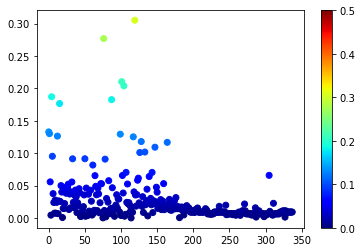

,release_year,production_year,text_embeddings7,img_embeddings4,text_embeddings4,genres0,studio10,genres2,genres3,studio69,studio8,genres21,studio21,studio14,studio40,genres14,genres5
3067,0.701910,1.047720,-0.234289,0.087647,0.441546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3246,0.104955,0.283471,-2.024523,-1.479974,-1.074851,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3503,0.224346,0.410846,0.639166,1.095860,0.392687,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,-0.372609,-0.098653,-0.132168,-0.051346,-0.589544,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3210,-1.566519,-1.372400,1.583562,-0.174668,-1.956431,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0.343737,0.410846,0.013752,1.686680,1.444598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533,0.821301,1.047720,0.098759,-0.677219,1.039489,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,-1.566519,-1.372400,1.030888,1.979183,0.662142,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
852,0.821301,1.175094,-1.442883,-0.425584,0.202538,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:

        
"""#sns.heatmap(abs(corr))

#print(X1['ratings'].to_frame())
corr = X1['ratings'].to_frame().corrwith(Y1)
sorted_arg = np.flip(np.array(np.argsort(corr)))
# print(sorted_arg)
print(corr)
# print(Y1)"""

corrs = []
for feature in X_train.keys():
    corrs.append(np.corrcoef(X_train[feature].to_numpy(), Y_train.to_numpy().T)[0,1])
corrs = np.abs(np.array(corrs))
cm = plt.cm.get_cmap('jet')
plt.scatter(np.arange(len(X_train.keys())), corrs, cmap=cm,vmin=0, vmax=0.5, c = corrs)
plt.colorbar()
plt.show()

threshold = 0.1
#index_threshold = np.
idx = np.argwhere(corrs >= threshold).flatten()
X_train_ = X_train.iloc[:,idx]
X_test_ = X_test.iloc[:,idx]
X_train_

In [10]:
# Compute the Root Mean Square Error
def compute_rmse(predict, target):
#     if target.flatten().shape[0] != 1:
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
#     else :
#         diff = target - predict
#         rmse = np.abs(diff)
    return float(rmse)


def run_kfold(kf, model, X_train_, Y_train_):

    X_train = np.vstack(X_train_.to_numpy())
    Y_train = np.vstack(Y_train_.to_numpy())
    Y_train *= 1e-6
    
#     scores = cross_val_score(model, X_train, Y_train, cv=5)
#     print(np.mean(scores), np.std(scores))
    RMSEs = []

    for train_index, test_index in kf.split(X_train):
        #print(train_index, test_index)
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        Y_train_fold, Y_test_fold = Y_train[train_index], Y_train[test_index]
    
        reg = model.fit(X_train_fold, Y_train_fold)
        pred = reg.predict(X_test_fold)
        
        RMSEs.append(compute_rmse(pred, Y_test_fold))
        

    return RMSEs



In [11]:
linear_regression = LinearRegression()


kf = KFold(n_splits=5, shuffle=True)
RMSEs_lin_reg = run_kfold(kf, linear_regression, X_train_, Y_train)
print(RMSEs_lin_reg)

reg = linear_regression.fit(np.vstack(X_train_.to_numpy()), np.vstack(Y_train.to_numpy())*1e-6)
pred = reg.predict(np.vstack(X_test_.to_numpy()))
print(compute_rmse(pred, Y_test*1e-6))

[45.01439675110632, 59.73811784682075, 41.21268606542838, 58.619329976828666, 58.30250276445372]
68.42477586960013


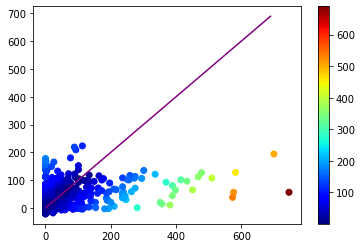

In [12]:
cm = plt.cm.get_cmap('jet')
flattenPred = pred.flatten()
flattenY = Y_test.to_numpy().flatten()*1e-6
diff = np.abs(flattenPred - flattenY)
plt.scatter(flattenY, flattenPred,cmap=cm,vmin=np.min(diff), vmax=np.max(diff), c = diff)
plt.colorbar()
# plt.yscale("log")
# plt.xscale("log")
ideal = np.linspace(np.min(diff), np.max(diff), 100)
plt.plot(ideal, ideal, c="purple")
plt.show()

In [13]:
# toDO delete feature least correlated to objective
correlated_features = getCorrelatedFeatures(X_train, 0.4)
print(correlated_features)
feature_to_remove = []
for tuples in correlated_features:
    if tuples[0] not in feature_to_remove:
        feature_to_remove.append(tuples[0])
        
print(feature_to_remove)
X_train.drop(feature_to_remove, axis=1, inplace=True)
X_test.drop(feature_to_remove, axis=1, inplace=True)

[('production_year', 'release_year'), ('genres2', 'genres11')]
0.7560104493145678
[('production_year', 'release_year'), ('genres2', 'genres11')]
['production_year', 'genres2']


2


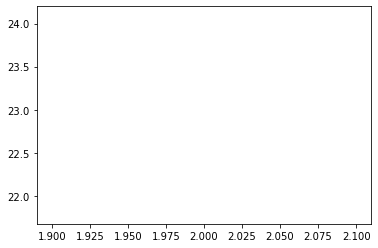

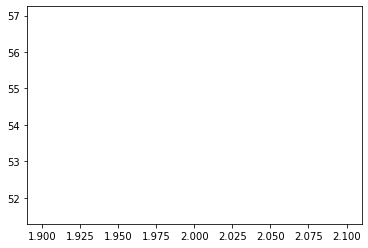

number of neighbors : 2


In [14]:
n_neighbors = 11
means = []
stds = []
n_neighborss = np.arange(2,51)
n_neighborss = np.arange(2,3)


for n_neighbors in n_neighborss:
    print(n_neighbors)
    knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors)

    kf = KFold(n_splits=X_train.shape[0]//2, shuffle=True)
    RMSEs_knn_neigh = run_kfold(kf, knn_reg, X_train, Y_train)
    means.append(np.mean(RMSEs_knn_neigh))
    stds.append(np.std(RMSEs_knn_neigh))
    
means = np.array(means)
stds = np.array(stds)
plt.plot(n_neighborss, means)
#plt.fill_between(n_neighborss, means-stds, means+stds, alpha=0.5)
plt.show()
#print(RMSEs_knn_neigh)

plt.plot(n_neighborss, stds)
plt.show()

print("number of neighbors : {}".format(np.argmin(means)+2))

In [15]:
n_neighbors = 12
knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors)
reg = knn_reg.fit(np.vstack(X_train.to_numpy()), np.vstack(Y_train.to_numpy())*1e-6)
pred = reg.predict(np.vstack(X_test.to_numpy()))
print(compute_rmse(pred, Y_test*1e-6))


75.80373976807643


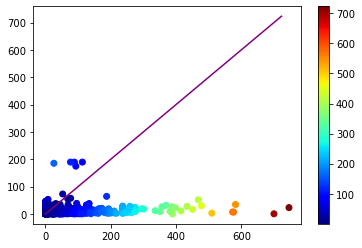

In [16]:
cm = plt.cm.get_cmap('jet')
flattenPred = pred.flatten()
flattenY = Y_test.to_numpy().flatten()*1e-6
diff = np.abs(flattenPred - flattenY)
plt.scatter(flattenY, flattenPred,cmap=cm,vmin=np.min(diff), vmax=np.max(diff), c = diff)
plt.colorbar()
# plt.yscale("log")
# plt.xscale("log")
ideal = np.linspace(np.min(diff), np.max(diff), 100)
plt.plot(ideal, ideal, c="purple")
plt.show()